In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from skimage.feature import hog


car_image_dirs = ["training"]
car_image_locations = glob.glob("./training/vehicles/**/*.png", recursive=True)
non_car_image_locations = glob.glob("./training/non-vehicles/**/*.png",recursive=True)

In [2]:
def read_image(filename):
    return mpimg.imread(filename)
    
car_images = [read_image(image) for image in car_image_locations]
non_car_images = [read_image(image) for image in non_car_image_locations]

In [17]:
def spatial_color_bin_feature(img,size=(32,32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1,color2,color3))

def color_hist_feature(img, nbins=32):
    chan1 = np.histogram(img[:,:,0], bins=nbins)
    chan2 = np.histogram(img[:,:,1], bins=nbins)
    chan3 = np.histogram(img[:,:,2], bins=nbins)
    hist_features = np.concatenate((chan1[0], chan2[0], chan3[0]))
    return hist_features

def hog_feature(img, orient=9, pix_per_cell=8, cell_per_block=2):
    hog_features = []
    for channel in range(img.shape[2]):
      hog_features.append(hog(img[:,:,channel], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=False, feature_vector=True))
    return np.ravel(hog_features)

def feature_vector(img):
    converted_color_space = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    resized_img = cv2.resize(converted_color_space, (64, 64))
    return np.concatenate( (color_hist_feature(resized_img), hog_feature(resized_img), spatial_color_bin_feature(resized_img)))



In [18]:
car_features = [ feature_vector(img) for img in car_images]
non_car_features = [feature_vector(img) for img in non_car_images]

/Users/mccuisto/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [19]:
from sklearn.preprocessing import StandardScaler


X = np.vstack([car_features,non_car_features]).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
print("shape:", X.shape)
scaled_X = X_scaler.transform(X)

y = np.hstack((np.ones(len(car_features)), 
              np.zeros(len(non_car_features))))


shape: (17760, 8460)


In [20]:
from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVC

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

svc = LinearSVC()
svc.fit(X_train, y_train)
print("shape: X_train: ", X_train.shape)
print("accuracy:", sum( svc.predict(X_test) == y_test ) / len(y_test))


shape: X_train:  (14208, 8460)
accuracy: 0.991272522523


In [21]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[400, None], 
                    xy_window=(32, 32), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


def generate_windows(img, window_sizes):
    windows = []
    for size in window_sizes:
        windows += slide_window(img, xy_window=size)
    return windows

In [30]:
def vehicle_search(img,svc,scaler,window_sizes):
  windows = generate_windows(img, window_sizes)
  rois = [img[location[0][1]:location[1][1], location[0][0]:location[1][0] ] for location in windows]
  vehicle_windows = []
  for window, roi in zip(windows, rois):
    reshaped = np.array([feature_vector(roi)])
    print(reshaped.shape)
    scaled_feature_vector = scaler.transform(reshaped)
    prediction = svc.predict(scaled_feature_vector)[0]
    if prediction == 1:
      print("found vehicle at {} with prediction {}".format(window, prediction))
      vehicle_windows.append(window)
      rois.append(roi)

  return vehicle_windows, rois

In [31]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def pipeline(img):
  cp = np.copy(img)
  boxes, rois = vehicle_search(img,svc,X_scaler,[(128,128),(192,192),(256,256)])
  heat = np.zeros_like(cp[:,:,0]).astype(np.float)
  heat = add_heat(heat,boxes)
  heat = apply_threshold(heat,1)
  heatmap = np.clip(heat, 0, 255)
  labels = label(heatmap)
  draw_img = draw_labeled_bboxes(cp, labels)
  return draw_img

/Users/mccuisto/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


(1, 8460)
found vehicle at ((0, 400), (128, 528)) with prediction 1.0
(1, 8460)
found vehicle at ((64, 400), (192, 528)) with prediction 1.0
(1, 8460)
found vehicle at ((128, 400), (256, 528)) with prediction 1.0
(1, 8460)
found vehicle at ((192, 400), (320, 528)) with prediction 1.0
(1, 8460)
found vehicle at ((256, 400), (384, 528)) with prediction 1.0
(1, 8460)
found vehicle at ((320, 400), (448, 528)) with prediction 1.0
(1, 8460)
found vehicle at ((384, 400), (512, 528)) with prediction 1.0
(1, 8460)
found vehicle at ((448, 400), (576, 528)) with prediction 1.0
(1, 8460)
found vehicle at ((512, 400), (640, 528)) with prediction 1.0
(1, 8460)
found vehicle at ((576, 400), (704, 528)) with prediction 1.0
(1, 8460)
found vehicle at ((640, 400), (768, 528)) with prediction 1.0
(1, 8460)
found vehicle at ((704, 400), (832, 528)) with prediction 1.0
(1, 8460)
found vehicle at ((768, 400), (896, 528)) with prediction 1.0
(1, 8460)
found vehicle at ((832, 400), (960, 528)) with prediction

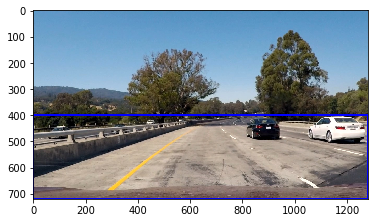

In [32]:
%matplotlib inline
test_image = read_image("./test_images/test1.jpg")
plt.imshow(pipeline(test_image))

/Users/mccuisto/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


(1, 8460)
found vehicle at ((0, 400), (128, 528)) with prediction 1.0
(1, 8460)
found vehicle at ((64, 400), (192, 528)) with prediction 1.0
(1, 8460)
found vehicle at ((128, 400), (256, 528)) with prediction 1.0
(1, 8460)
found vehicle at ((192, 400), (320, 528)) with prediction 1.0
(1, 8460)
found vehicle at ((256, 400), (384, 528)) with prediction 1.0
(1, 8460)
found vehicle at ((320, 400), (448, 528)) with prediction 1.0
(1, 8460)
found vehicle at ((384, 400), (512, 528)) with prediction 1.0
(1, 8460)
found vehicle at ((448, 400), (576, 528)) with prediction 1.0
(1, 8460)
found vehicle at ((512, 400), (640, 528)) with prediction 1.0
(1, 8460)
found vehicle at ((576, 400), (704, 528)) with prediction 1.0
(1, 8460)
found vehicle at ((640, 400), (768, 528)) with prediction 1.0
(1, 8460)
found vehicle at ((704, 400), (832, 528)) with prediction 1.0
(1, 8460)
found vehicle at ((768, 400), (896, 528)) with prediction 1.0
(1, 8460)
found vehicle at ((832, 400), (960, 528)) with prediction

[((0, 400), (128, 528)), ((64, 400), (192, 528)), ((128, 400), (256, 528)), ((192, 400), (320, 528)), ((256, 400), (384, 528)), ((320, 400), (448, 528)), ((384, 400), (512, 528)), ((448, 400), (576, 528)), ((512, 400), (640, 528)), ((576, 400), (704, 528)), ((640, 400), (768, 528)), ((704, 400), (832, 528)), ((768, 400), (896, 528)), ((832, 400), (960, 528)), ((896, 400), (1024, 528)), ((960, 400), (1088, 528)), ((1024, 400), (1152, 528)), ((1088, 400), (1216, 528)), ((1152, 400), (1280, 528)), ((0, 464), (128, 592)), ((64, 464), (192, 592)), ((128, 464), (256, 592)), ((192, 464), (320, 592)), ((256, 464), (384, 592)), ((320, 464), (448, 592)), ((384, 464), (512, 592)), ((448, 464), (576, 592)), ((512, 464), (640, 592)), ((576, 464), (704, 592)), ((640, 464), (768, 592)), ((704, 464), (832, 592)), ((768, 464), (896, 592)), ((832, 464), (960, 592)), ((896, 464), (1024, 592)), ((960, 464), (1088, 592)), ((1024, 464), (1152, 592)), ((1088, 464), (1216, 592)), ((1152, 464), (1280, 592)), (

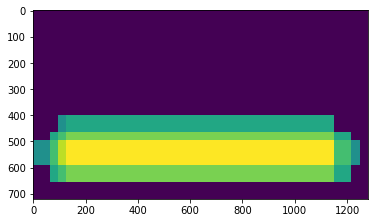

In [33]:
def draw(img):
  cp = np.copy(img)
  boxes, rois = vehicle_search(img,svc,X_scaler,[(128,128),(192,192),(256,256)])
  heat = np.zeros_like(cp[:,:,0]).astype(np.float)
  heat = add_heat(heat,boxes)
  heat = apply_threshold(heat,4)
  heatmap = np.clip(heat, 0, 255)
  labels = label(heatmap)
  draw_img = draw_labeled_bboxes(cp, labels)
  print(boxes)
  return heatmap

test_image = read_image("./test_images/test1.jpg")
plt.imshow(draw(test_image))


In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
    
video_output = 'test_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
clip = clip1.fl_image(pipeline)
%time clip.write_videofile(video_output, audio=False)

In [ ]:
plt.imshow(processed_images[10])

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="./{0}" type="video/mp4">
</video>
""".format(video_output))